In [1]:
import utils
import r_pca
import numpy as np
from pylab import plt

%load_ext autoreload
%autoreload 2

In [2]:
d = 10
n = 2 ** d
left = 0
right = 1
signal = utils.values(np.sqrt, left, right, n)
modes = [2] * d

In [3]:
filters, sparse_parts, ranks = utils.wtt_rpca_v3(
    signal,
    d,
    modes,
    ranks=None,
    eps=1e-6,
    lambda_scale=2.5,
    verbose=False
)

In [4]:
[u.shape for u in filters]

[(2, 2),
 (4, 4),
 (8, 8),
 (14, 14),
 (14, 14),
 (14, 14),
 (12, 12),
 (10, 10),
 (8, 8),
 (4, 4)]

In [5]:
[u.shape for u in sparse_parts]

[(2, 512),
 (4, 256),
 (8, 128),
 (16, 64),
 (32, 32),
 (64, 16),
 (128, 8),
 (256, 4),
 (512, 2),
 (1024, 1)]

In [6]:
[u.data.size for u in sparse_parts]

[22, 43, 42, 17, 1, 8, 12, 21, 0, 0]

In [7]:
wtt_result = utils.wtt_apply_rpca_v3(
    signal,
    d,
    filters,
    sparse_parts,
    modes,
    ranks
)

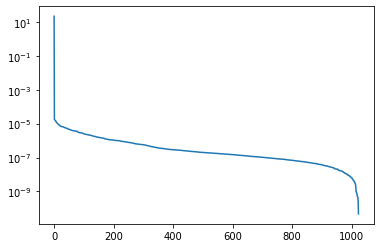

In [8]:
plt.plot(np.arange(wtt_result.size), np.flip(np.sort(np.abs(wtt_result))))
plt.yscale('log')
plt.show()

In [9]:
iwtt_result = utils.iwtt_apply_rpca_v3(
    wtt_result,
    d,
    filters,
    sparse_parts,
    modes,
    ranks
)

In [10]:
np.linalg.norm(signal - iwtt_result)

1.1629729146676057e-14

Восстановим:

In [11]:
(np.abs(wtt_result) <= 1e-6).sum()

810

In [12]:
wtt_result[np.abs(wtt_result) <= 1e-6] = 0
iwtt_result = utils.iwtt_apply_rpca_v3(
    wtt_result,
    d,
    filters,
    sparse_parts,
    modes,
    ranks
)
print(np.linalg.norm(signal - iwtt_result))

8.877809860662998e-06


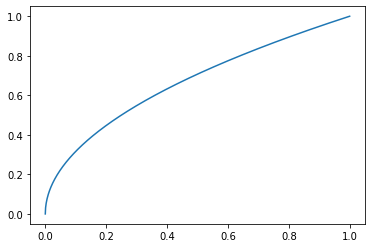

In [13]:
#plt.plot(np.linspace(left, right, n), signal)
plt.plot(np.linspace(left, right, n), iwtt_result)

Тестируем тензоризованный препроцессинг.

In [32]:
low_rank_part, sparse_parts, ranks = r_pca.wtt_rpca_preprocessing(
    signal,
    d,
    modes,
    lambda_scale=2.5 #как выше, ведь идея такая же
)

Current step 0
Current step 1
Current step 2
Current step 3
Current step 4
Current step 5
Current step 6
Current step 7
Current step 8
Current step 9


In [33]:
low_rank_part

array([0.08122468, 0.08245917, 0.08389766, ..., 0.99919015, 0.99966313,
       1.0001043 ])

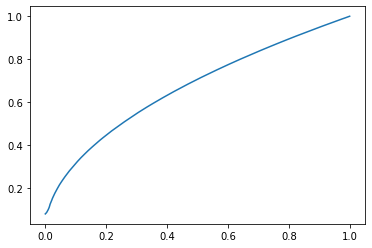

In [49]:
plt.plot(np.linspace(left, right, n), low_rank_part)
plt.show()

Что-то очень похожее на оригинальный корень, между прочим!

In [50]:
np.linalg.norm(low_rank_part - signal)

0.11490225428994431

Посмотрим на характеристики разложения:

In [51]:
[s.data.size for s in sparse_parts]

[22, 38, 23, 17, 0, 7, 8, 27, 0, 0]

In [52]:
ranks

[2, 3, 3, 5, 4, 4, 4, 3, 2]

Попробуем теперь разложить малоранговую часть, что ли...

In [53]:
filters, true_ranks = utils.wtt_filter(
    low_rank_part,
    d,
    modes,
    ranks=ranks
)

In [54]:
true_ranks

[2, 3, 3, 5, 4, 4, 4, 3, 2]

In [55]:
wtt_res = utils.wtt_apply(
    low_rank_part,
    d,
    filters,
    modes,
    true_ranks
)

Что получилось:

In [56]:
np.max(wtt_res[1:])

1.6699601677629413e-14

Все коэффициенты, кроме первого --- нули! А ранги при этом крошечные.

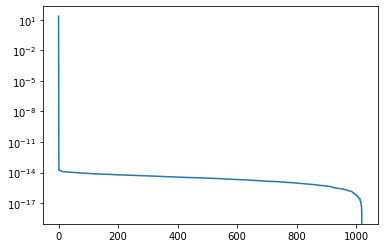

In [57]:
plt.plot(np.arange(wtt_res.size), np.flip(np.sort(np.abs(wtt_res))))
plt.yscale('log')
plt.show()

In [58]:
zeroed_coeffs = np.zeros_like(wtt_res)
zeroed_coeffs[0] = wtt_res[0]

iwtt_res = utils.iwtt_apply(
    zeroed_coeffs,
    d,
    filters,
    modes,
    true_ranks
)

print(np.linalg.norm(iwtt_res - low_rank_part))

1.543434328854317e-13


Восстановим корень:

In [65]:
signal - utils.subtract_sparse_parts(signal, d, modes, sparse_parts)

array([-0.08119197, -0.05119314, -0.03968629, ...,  0.        ,
        0.        ,  0.        ])

Всё же у нас приближённое разложение $A = L + S_1 + \ldots + S_d$ (параметр ```tol``` в алгоритме).

In [67]:
signal_restored = utils.add_sparse_parts(iwtt_res, d, modes, sparse_parts)
np.linalg.norm(signal - signal_restored)

0.0039026710338845006

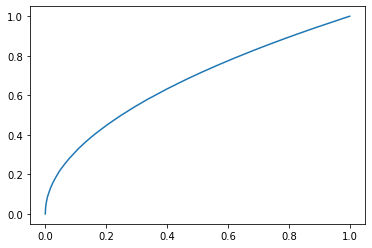

In [70]:
plt.plot(np.linspace(left, right, n), signal_restored)
plt.show()

Теперь посмотрим на простое 2D:

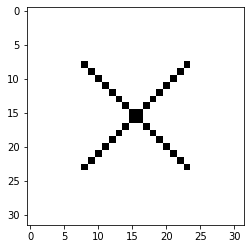

In [82]:
cross = np.full((32, 32), 1.)
for i in range(8, 24):
    cross[i, i] = 0.
    cross[i, 31 - i] = 0.
plt.imshow(cross, cmap='gray')

In [83]:
d = 5
modes = [2] * d

vector, vector_modes = utils.matrix_to_vector(cross, d, modes)

In [84]:
low_rank_part, sparse_parts, ranks = r_pca.wtt_rpca_preprocessing(
    vector,
    d,
    vector_modes,
    lambda_scale=2
)

Current step 0
Current step 1
Current step 2
Current step 3
Current step 4


In [85]:
matrix, _ = utils.vector_to_matrix(low_rank_part, d, vector_modes)

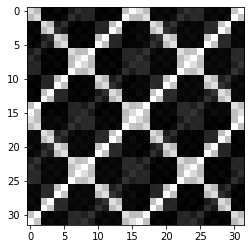

In [86]:
plt.imshow(matrix, cmap='gray')

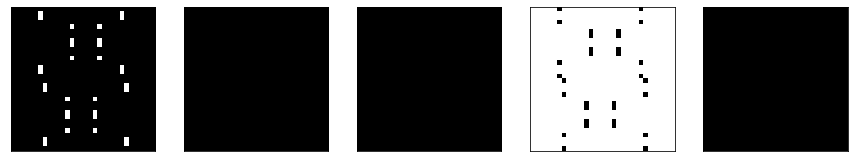

In [87]:
fig = plt.figure(figsize=(15, 3))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        sparse_parts[i].toarray().reshape((32, 32), order='F'),
        #sparse_parts[i].toarray(),
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])

In [90]:
[s.data.size for s in sparse_parts]

[32, 0, 0, 64, 0]